In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gym

from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

#### SubEnvironment

This environment models a single asset that oscillates via Sine wave with optional noise.  The asset fluctuates in value, and the agent must either hold (not do anything) or invest in the asset.

The reward is based on the agent's decision and the value of the asset.  If the decision is to hold, then the reward is 0.  If the decision is to invest, then the reward is equal to the value.  The value can range from -1 to 1.

Ideally, the agent will properly forecast the next timestep's value, and choose to hold if it's negative and to invest if it's positive.

In [ ]:
class SubEnvironment:
    def __init__(self, lookback=10, max_steps=100, noise=0, seed=None):
        # how much of the value history the agent sees
        self.lookback = lookback
        
        # available actions (hold/invest)
        self.action_space = gym.spaces.Discrete(2)
        
        # observation space (lookback)
        self.observation_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(self.lookback,), dtype=np.float32)
        
        # how long an episode lasts
        self.max_steps = max_steps
        
        # noise to apply to the value
        self.noise = noise
        
        # set a seed for testing
        self.seed = seed
        
    def reset(self, seed=None):
        if self.seed:
            np.random.seed(self.seed)
        if seed:
            np.random.seed(seed)
            
        # The current timestep
        self.t = self.lookback
        
        # The rewards of the episode
        self.current_reward = 0.
        self.episode_rewards = [self.current_reward]
        
        # Our "time" space
        self.x_space = np.arange(self.max_steps)
        
        # Our "asset" space
        a_c = np.random.randint(2,17)
        self.a_space = np.sin(np.linspace(0,a_c*np.pi,self.max_steps))
        self.a_space += np.random.normal(0, self.noise, size=self.a_space.shape)
        self.a_space = np.clip(self.a_space, -1., 1.)
        
        # The current "viewable" observation
        self.observation = self.a_space[self.t-self.lookback:self.t]
        
        # The current position of the agent (0: neutral, 1: long)
        self.position = 0
        
        return self.observation.reshape(self.observation_space.shape)
    
    def step(self, action):
        # increment time
        self.t += 1
        
        # update observation
        self.observation = self.a_space[self.t-self.lookback:self.t]
        
        # our current asset value
        current = self.observation[-1]
        
        # our current position
        self.position = action
        
        # the reward for our position
        # e.g., if our position == 0 (neutral), then we gain no reward
        # if our position == 1 (long), then we gain/lose the change
        instantaneous_reward = self.position * current
        self.current_reward += instantaneous_reward
        self.episode_rewards.append(self.current_reward)
        
        done = False
        if self.t >= self.max_steps - 1:
            done = True
            
        return self.observation.reshape(self.observation_space.shape), instantaneous_reward, done, {}
    
    def render(self):
        fig, ax = plt.subplots(1,2,figsize=(12,4),gridspec_kw = {'width_ratios':[2, 1]})

        ax[0].plot(self.x_space, self.a_space)
        ax[0].plot([self.t], [self.a_space[self.t]], 'ro')
        ax[1].plot(self.episode_rewards)

        plt.show()

Next, we test the subenvironment.  Here, we take random actions after every step and plot every 10 steps.

In [ ]:
env = SubEnvironment(noise=0.1)
env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, rew, done, info = env.step(action)
    if (env.t + 1) % 10 == 0:
        env.render()

#### SubAgent

Here, we define the sub-agent.  This is simply a PPO agent with no modifications.

In [165]:
class SubAgent:
    def __init__(self, env,
                epsilon=0.2, gamma=0.99, entropy_loss=1e-3, actor_lr=0.001, critic_lr=0.005,
                hidden_size=128, epochs=10, batch_size=64, buffer_size=256):
        # Clear Tensorflow session and set some metadata
        K.clear_session()
        self.env = env
        
        self.action_space = env.action_space
        self.observation_space = env.observation_space
        
        # Set hyperparameters
        self.epsilon = epsilon
        self.gamma = gamma
        self.entropy_loss = entropy_loss
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        
        # Build Actor and Critic models
        self.actor = self.build_actor() 
        self.critic = self.build_critic()
        
        # When we want predictions of actions, we need to pass in three things:
        # the observation, the old prob, and the advantage.
        # Here, we just created data to spoof the last two.
        self.DUMMY_ACTION, self.DUMMY_VALUE = np.zeros((1,self.action_space.n)), np.zeros((1,1))

    def proximal_policy_optimization_loss(self, advantage, old_pred, debug=True):
        
        # Defines the PPO loss to be used during actor optimization
        def loss(y_true, y_pred):
            
            # advantage is a vector of size 1 passed in from the critic
            # This summing flattens it
            adv = K.sum(advantage, axis=1)
            if debug:
                adv = K.print_tensor(adv, 'advantage     :')

            # y_true is one-hot vector denoting the action taken
            # y_pred is the output of the actor neural network
            # for the given observation
            # e.g., y_true = [0,1,0], y_pred = [0.2, 0.5, 0.3]
            # so prob = y_true * y_pred = [0, 0.5, 0]
            if debug:
                y_true = K.print_tensor(y_true, 'y_true        :')
                y_pred = K.print_tensor(y_pred, 'y_pred        :')
                
            prob = y_true * y_pred
            if debug:
                prob = K.print_tensor(prob, 'prob          :')

            # old_pred is the actor's previous probabilty distribution
            # for the given observation
            # e.g., y_true = [0,1,0], old_pred = [0.2, 0.4, 0.4]
            # so prob = y_true * old_pred = [0, 0.4, 0]
            old_prob = y_true * old_pred
            if debug:
                old_prob = K.print_tensor(old_prob, 'old_prob      :')

            # r is the ratio of the old probability to the new one
            # e.g., r = prob/old_prob = [0, 0.5/0.4, 0]
            r = K.sum(prob/(old_prob + 1e-10), axis=1)
            if debug:
                r = K.print_tensor(r, 'r             :')

            # clipped is the value of r clipped between 1 +/- epsilon
            # e.g., r = 1.4, epsilon = 0.2 => clipped = 1.2
            clipped = K.clip(r, min_value=1-self.epsilon, max_value=1+self.epsilon)
            if debug:
                clipped = K.print_tensor(clipped, 'clipped       :')

            # minimum is the min of r * advantage and clipped * advantage
            minimum = K.minimum(r * adv, clipped * adv)
            if debug:
                minimum = K.print_tensor(minimum, 'minimum       :')

            # entropy bonus (to encourage exploration)
            entropy_bonus = self.entropy_loss * (prob * K.log(prob + 1e-10))
            entropy_bonus = K.sum(entropy_bonus, axis=1)
            if debug:
                entropy_bonus = K.print_tensor(entropy_bonus, 'entropy_bonus :')

            # K.mean computes the mean over all dimensions (left with a scaler)
            result = -K.mean(minimum + entropy_bonus)
            if debug:
                result = K.print_tensor(result, 'result        :')

            return result
        return loss
    
    def build_actor(self):
        # actor has three inputs: the current state, the advantage,
        # and the agent's predicted probability for the given observation
        state_inputs = Input(shape=self.observation_space.shape)
        advantage = Input(shape=(1,))
        old_pred = Input(shape=(self.action_space.n,))
        
        # hidden layers
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        
        # the output is a probability distribution over the actions
        out_actions = Dense(self.action_space.n, activation='softmax')(x)

        model = Model(inputs=[state_inputs, advantage, old_pred],
                      outputs=[out_actions])
        
        # compile the model using our custom loss function
        model.compile(optimizer=Adam(lr=self.actor_lr),
                      loss=[self.proximal_policy_optimization_loss(
                          advantage=advantage,
                          old_pred=old_pred
                      )])
        return model
    
    def build_critic(self):
        # critic recieves the observation as input
        state_inputs = Input(shape=self.observation_space.shape)
        
        # hidden layers
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        
        # we predict the value of the current observation
        # i.e., cumulative discounted reward
        predictions = Dense(1, activation='linear')(x)

        model = Model(inputs=state_inputs, outputs=predictions)
        model.compile(optimizer=Adam(lr=self.critic_lr),
                      loss='mse')
        return model
    
    def get_action(self, observation):
        # Predict the probability destribution of the actions as a vactor
        prob = self.actor.predict([np.array([observation]), 
                                   self.DUMMY_VALUE, 
                                   self.DUMMY_ACTION])
        prob = prob.flatten()
        
        # Sample an action as a scaler
        action = np.random.choice(self.action_space.n, 1, p=prob)[0]
        
        # Vectorize the action as a one-hot encoding
        action_vector = np.zeros(self.action_space.n)
        action_vector[action] = 1
        
        return action, action_vector, prob
    
    def train_batch(self, observations, actions, probabilities, rewards):
        # limit our data to the buffer_size
        obs = observations[:self.buffer_size]
        acts = actions[:self.buffer_size]
        probs = probabilities[:self.buffer_size]
        rews = rewards[:self.buffer_size]
        
        # our 'old probs' are really just the batches probs
        old_probs = probs
        
        # Calculate advantages
        values = self.critic.predict(obs).reshape((self.buffer_size, 1))
        advs = rews - values
            
        # Train the actor and critic on the batch data
        self.actor.fit([obs, advs, old_probs], [acts],
                       batch_size=self.batch_size, shuffle=True,
                       epochs=self.epochs, verbose=False)
        self.critic.fit([obs], [rews],
                       batch_size=self.batch_size, shuffle=True,
                        epochs=self.epochs, verbose=False)
    
    def run(self, env, episodes, verbose=False):
        episode = 0
        reward_history = []

        # reset the environment
        observation = env.reset()

        # Collect a batch of samples
        while episode < episodes:
            # 'Master Batch' that we add mini batches to
            batch = {
                'observation': [],
                'action_vector': [],
                'probability': [],
                'reward': []
            }

            # Mini batch which contains a single episode's data
            tmp_batch = {
                'observation': [],
                'action_vector': [],
                'probability': [],
                'reward': []
            }

            # While we don't hit the buffer size with our master batch...
            while len(batch['observation']) < self.buffer_size:
                # Get the action (scalar), action vector (one-hot vector), 
                # and probability distribution (vector) from the current observation
                action, action_vector, prob = self.get_action(observation)

                # Get the next observation, reward, done, and info for taking an action
                next_observation, reward, done, info = env.step(action)

                # Append the data to the mini batch
                tmp_batch['observation'].append(observation)
                tmp_batch['action_vector'].append(action_vector)
                tmp_batch['probability'].append(prob)
                tmp_batch['reward'].append(reward)

                # The current observation is now the 'next' observation
                observation = next_observation

                # if the episode is at a terminal state...
                if done:
                    # log some reward data (for plotting)
                    reward_data = np.sum(tmp_batch['reward'])
                    reward_history.append(reward_data)

                    # transform rewards based to discounted cumulative rewards
                    for j in range(len(tmp_batch['reward']) - 2, -1, -1):
                        tmp_batch['reward'][j] += tmp_batch['reward'][j + 1] * self.gamma

                    # for each entry in the mini batch...
                    for i in range(len(tmp_batch['observation'])):
                        # we unpack the data
                        obs = tmp_batch['observation'][i]
                        act = tmp_batch['action_vector'][i]
                        prob = tmp_batch['probability'][i]
                        r = tmp_batch['reward'][i]

                        # and pack it into the master batch
                        batch['observation'].append(obs)
                        batch['action_vector'].append(act)
                        batch['probability'].append(prob)
                        batch['reward'].append(r)

                    # every 10th episode, log some stuff
                    if (episode+1) % 10 == 0 and verbose:
                        print('Episode:', episode)
                        print('Reward :', reward_data)
                        print('Average:', np.mean(reward_history[-100:]))
                        print('-'*10)
                        print()

                        env.render()
                
                    # reset the environment
                    observation = env.reset()

                    # reset the mini batch
                    tmp_batch = {
                        'observation': [],
                        'action_vector': [],
                        'probability': [],
                        'reward': []
                    }

                    # increment the episode count
                    episode += 1

            # we've filled up our master batch, so we unpack it into numpy arrays
            observations = np.array(batch['observation'])
            actions = np.array(batch['action_vector'])
            probabilities = np.array(batch['probability'])
            rewards = np.array(batch['reward'])    
            rewards = np.reshape(rewards, (len(batch['reward']), 1))

            # train the agent on the batched data
            self.train_batch(observations, actions, probabilities, rewards)
                    
        self.reward_history = reward_history
        return self.reward_history

## Training SubAgents

Here, we demonstrate how the subagents can be trained to "trade" the assets so as to maximize "profit."

Episode: 9
Reward : 13.337015744940656
Average: 2.644056309749759
----------



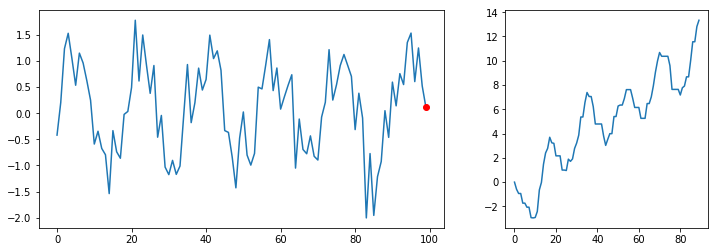

Episode: 19
Reward : 5.277425275044787
Average: 4.265814801065637
----------



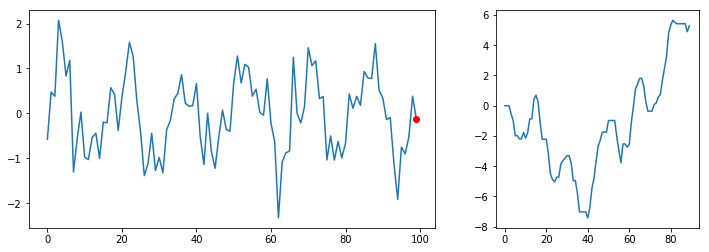

Episode: 29
Reward : 11.77513993206832
Average: 6.173092226489013
----------



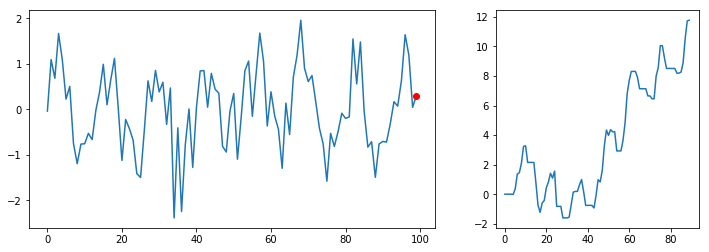

Episode: 39
Reward : 3.335970274950638
Average: 5.530949096357051
----------



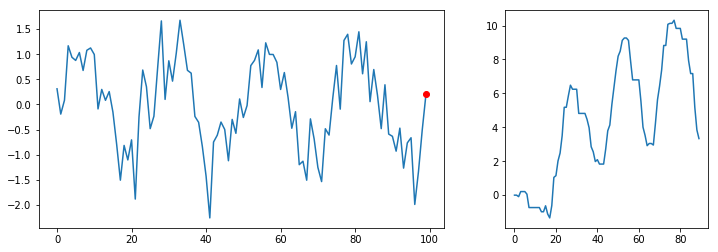

Episode: 49
Reward : 22.489972772773775
Average: 7.844742912971887
----------



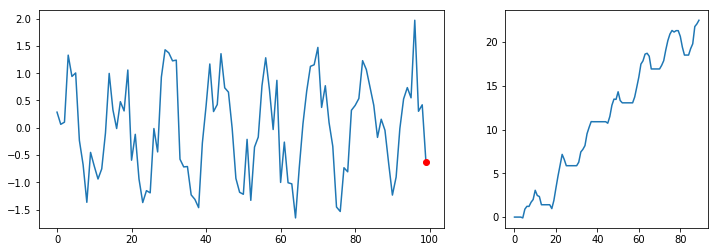

Episode: 59
Reward : 17.109220386248815
Average: 9.281031449316945
----------



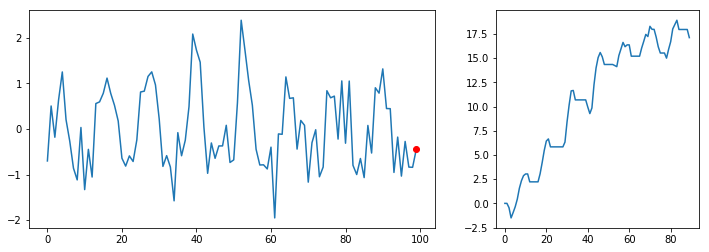

Episode: 69
Reward : 17.906728050422018
Average: 10.45295405779135
----------



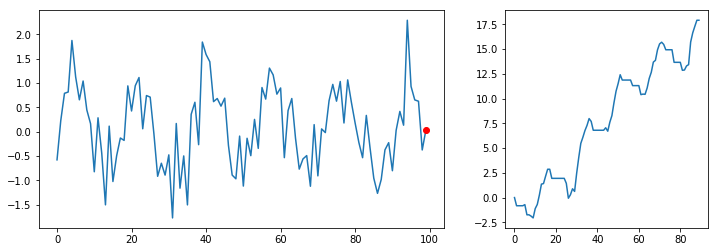

Episode: 79
Reward : 14.481846124319315
Average: 10.671019111465341
----------



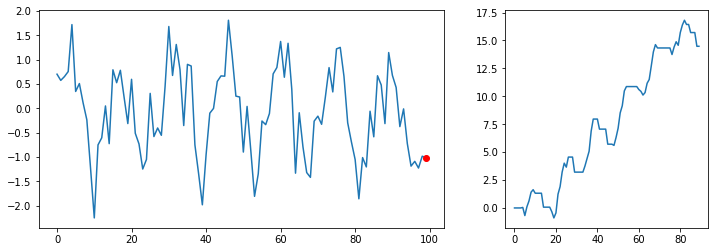

Episode: 89
Reward : 14.356088405822657
Average: 10.999577779069979
----------



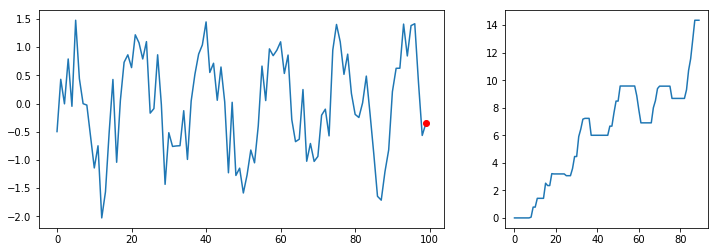

Episode: 99
Reward : 17.943362744627684
Average: 11.42260950609929
----------



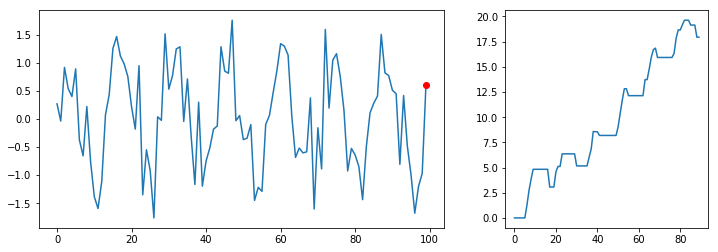

Episode: 109
Reward : 22.343616325882223
Average: 12.689680544191994
----------



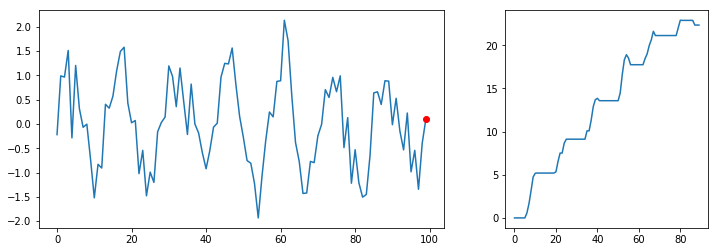

Episode: 119
Reward : 21.440840276825966
Average: 13.99512261358617
----------



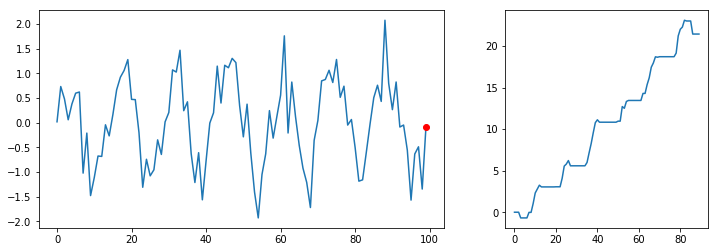

Episode: 129
Reward : 19.01852560124336
Average: 14.485657004997513
----------



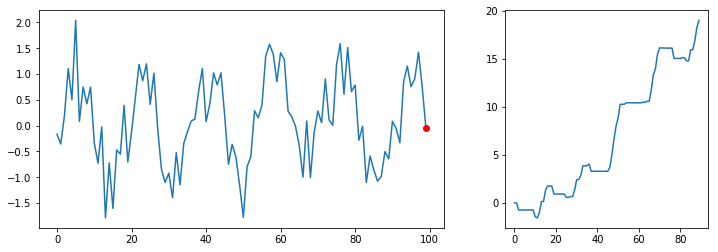

Episode: 139
Reward : 24.665574066513223
Average: 16.035302972500197
----------



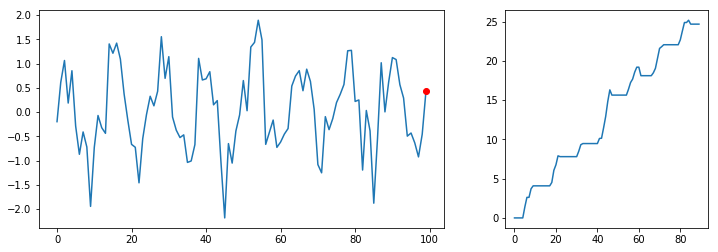

Episode: 149
Reward : 23.674492524375967
Average: 16.246025735535227
----------



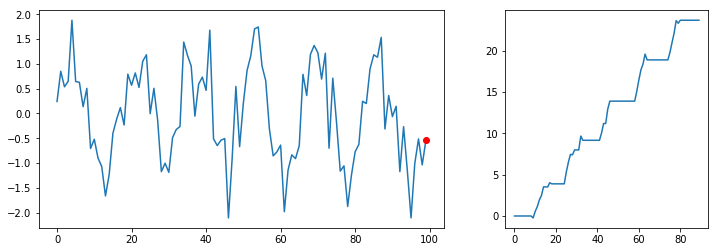

Episode: 159
Reward : 14.255023696439888
Average: 16.416730270353128
----------



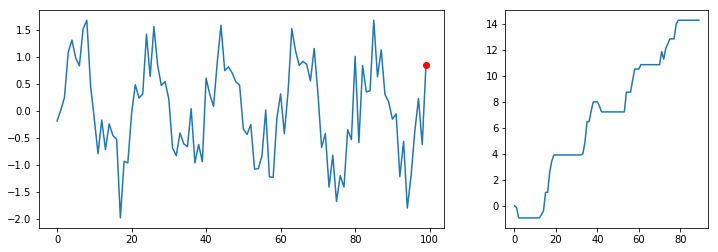

Episode: 169
Reward : 22.52222523164704
Average: 16.366405748753053
----------



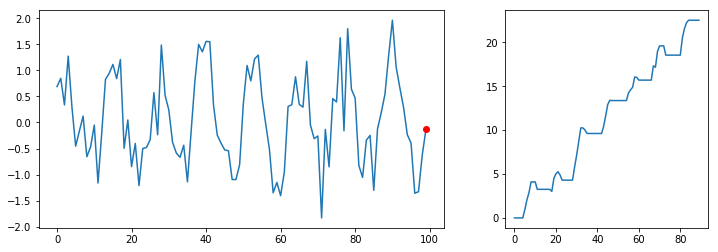

Episode: 179
Reward : 20.208450163628385
Average: 17.09797523682356
----------



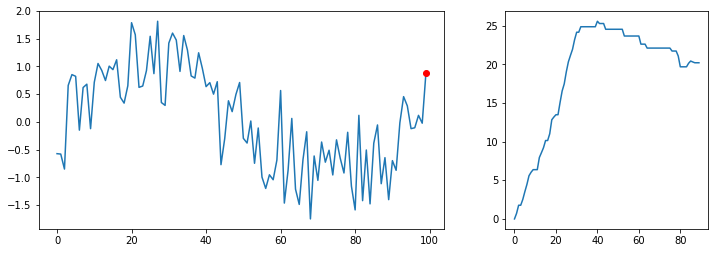

Episode: 189
Reward : 26.614268888426487
Average: 17.53348194596721
----------



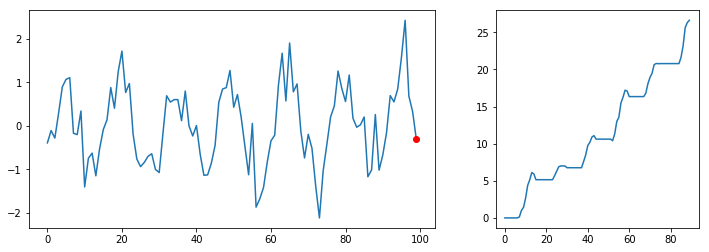

Episode: 199
Reward : 23.68328593814315
Average: 18.046902969221335
----------



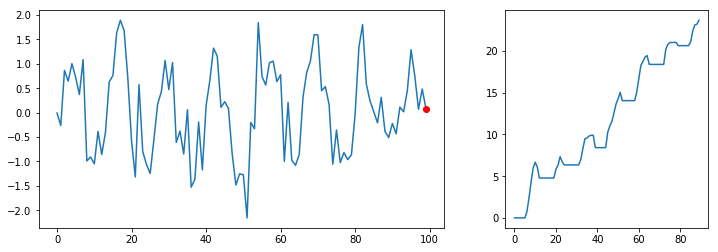

Episode: 209
Reward : 16.416288369308994
Average: 18.71645402502409
----------



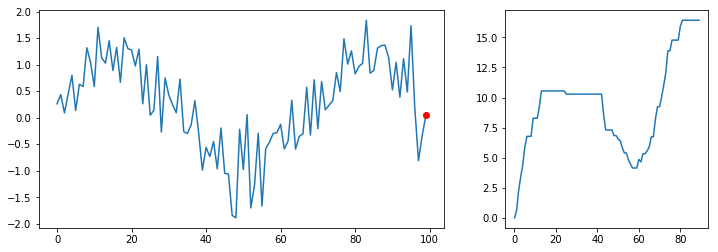

Episode: 219
Reward : 15.62179622872285
Average: 18.693175962967242
----------



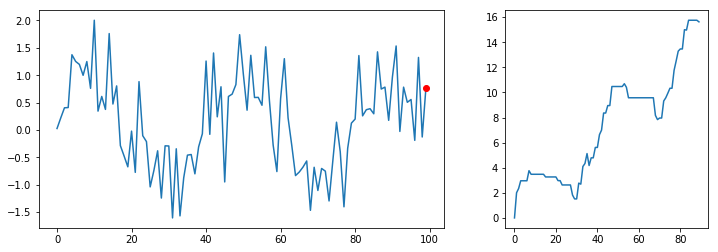

Episode: 229
Reward : 10.104084998908807
Average: 18.784665940863874
----------



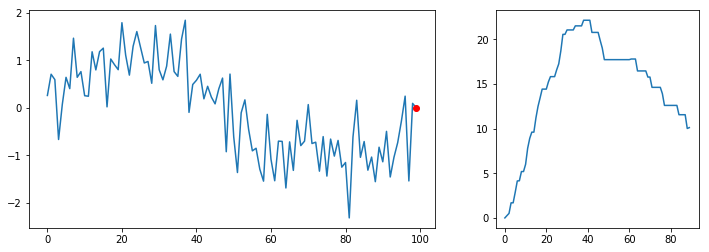

Episode: 239
Reward : 23.179003182886625
Average: 18.71267761309363
----------



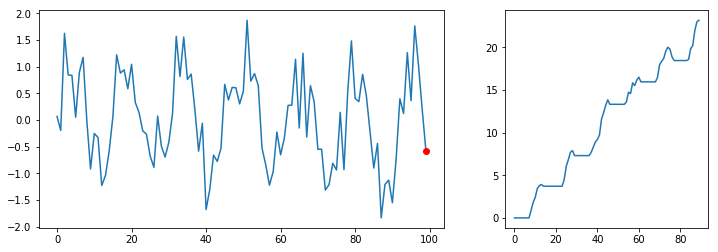

Episode: 249
Reward : 16.861061264883475
Average: 18.7221833553292
----------



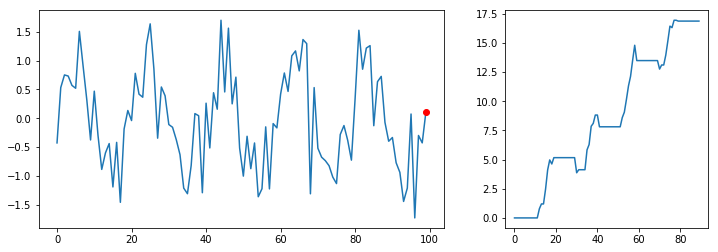

Episode: 259
Reward : 24.143809870317508
Average: 19.03459240918697
----------



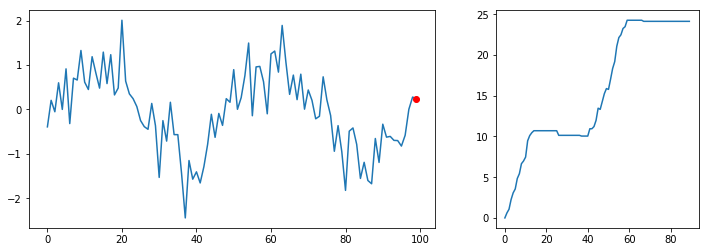

Episode: 269
Reward : 8.570104742533372
Average: 19.482108011389272
----------



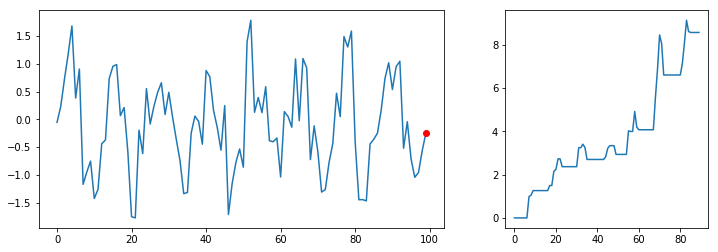

Episode: 279
Reward : 26.36766198315467
Average: 19.83170951273022
----------



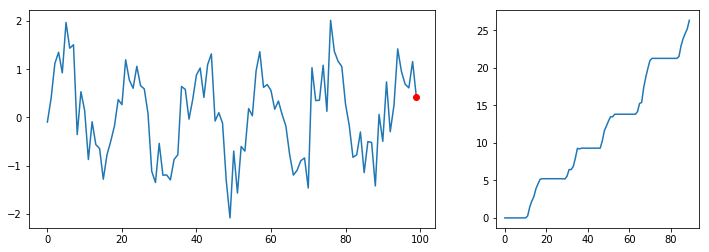

Episode: 289
Reward : 18.08755636022829
Average: 20.140114021535904
----------



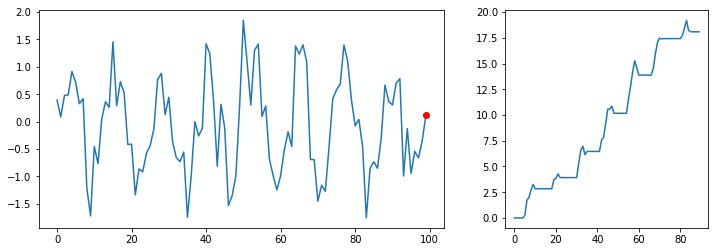

Episode: 299
Reward : 24.876439300796143
Average: 20.187933511124452
----------



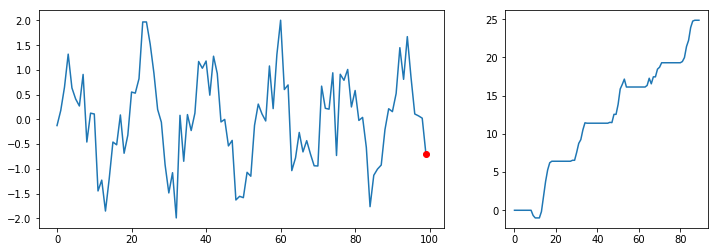

Episode: 309
Reward : 6.417388917413806
Average: 19.544154220237964
----------



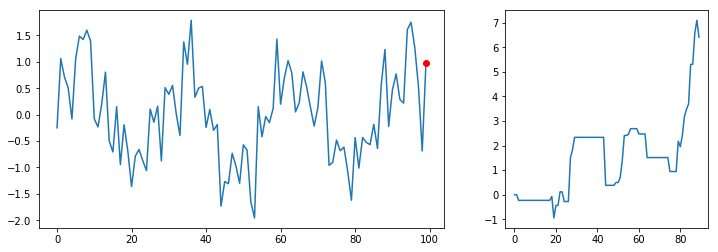

Episode: 319
Reward : 16.201200373629526
Average: 19.471372281188977
----------



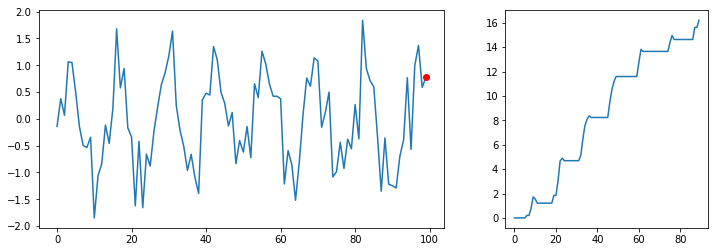

Episode: 329
Reward : 11.612873586596317
Average: 20.012403620284985
----------



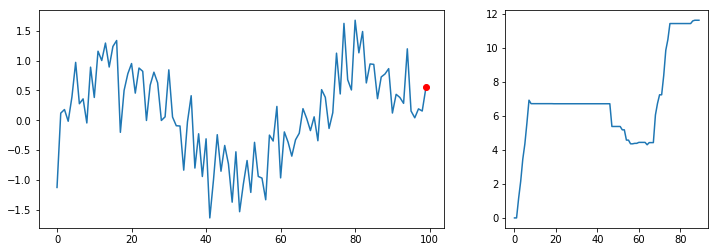

Episode: 339
Reward : 19.866984491084693
Average: 20.02884946915844
----------



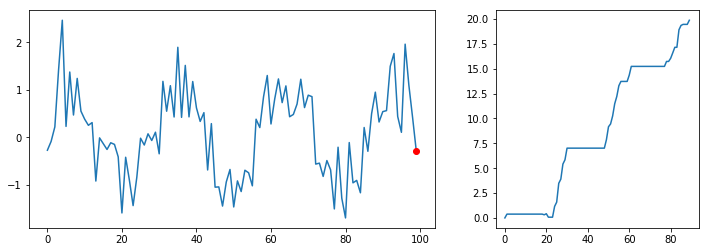

Episode: 349
Reward : 27.22142976759607
Average: 20.37613936863734
----------



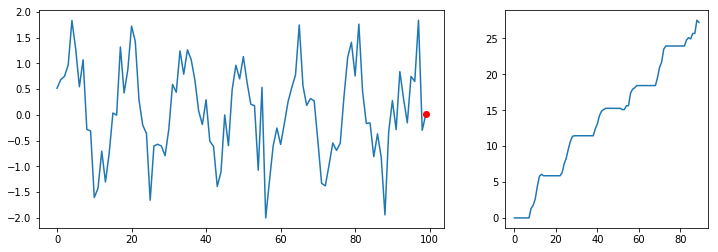

Episode: 359
Reward : 29.32123221119613
Average: 20.63677171968884
----------



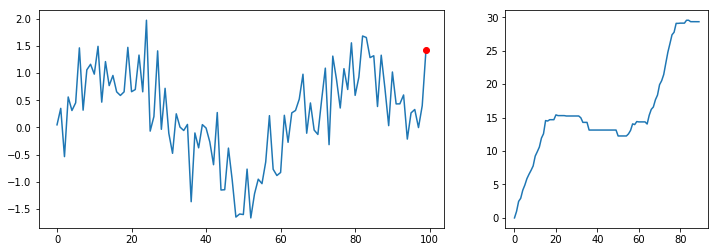

Episode: 369
Reward : 24.619738406009656
Average: 20.810758673634464
----------



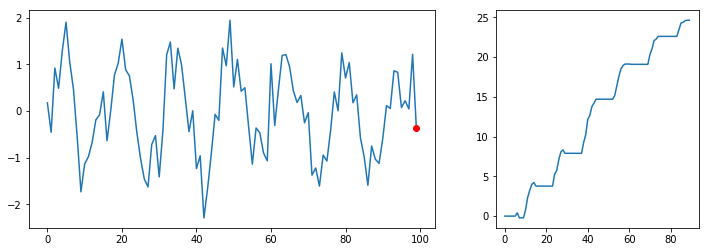

Episode: 379
Reward : 14.49424262560369
Average: 20.818237737923535
----------



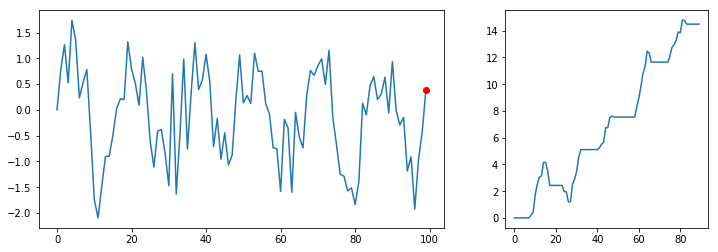

Episode: 389
Reward : 27.471178131405964
Average: 21.134760520375476
----------



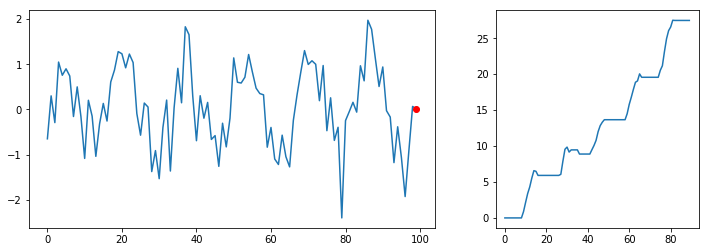

Episode: 399
Reward : 25.10925438652869
Average: 21.41537621275357
----------



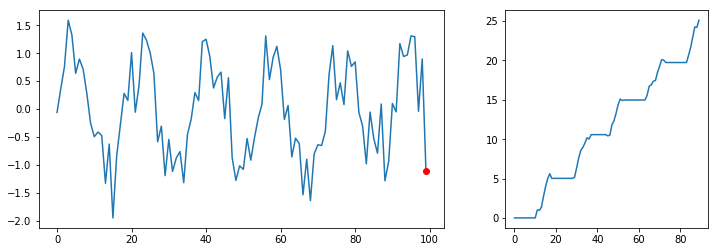

Episode: 409
Reward : 30.232662823509514
Average: 21.873936686221885
----------



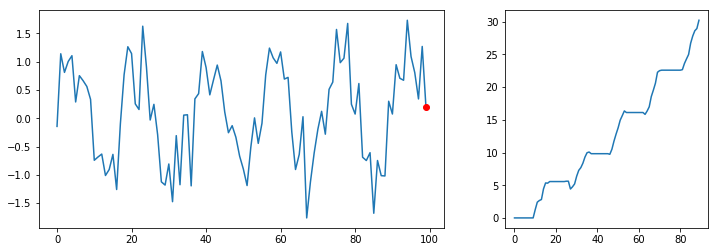

Episode: 419
Reward : 19.98623543692848
Average: 22.024458204439803
----------



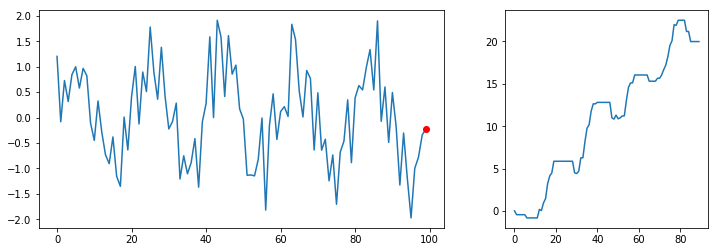

Episode: 429
Reward : 19.566223024745057
Average: 22.254244005842764
----------



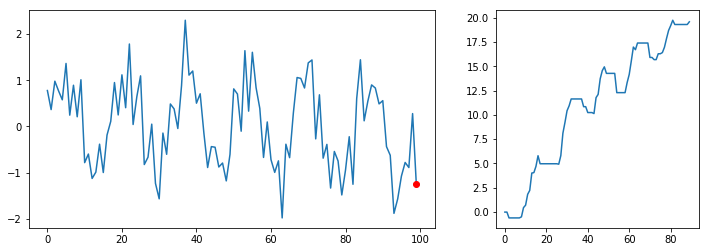

Episode: 439
Reward : 14.750889871846626
Average: 22.071678442833473
----------



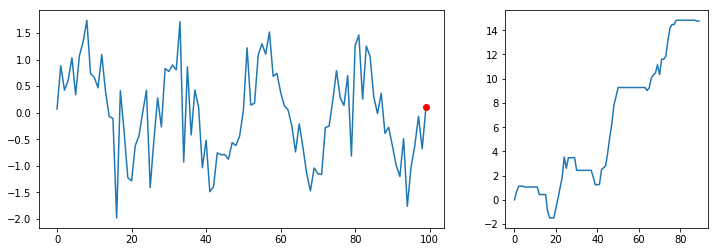

Episode: 449
Reward : 20.880189432510313
Average: 21.64566848755414
----------



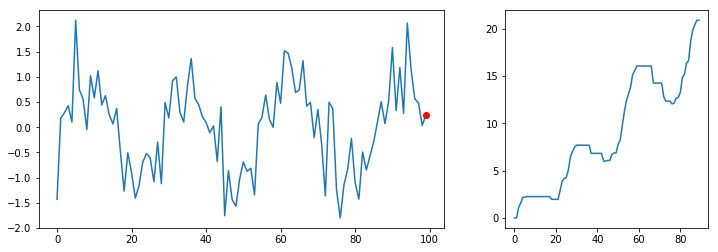

Episode: 459
Reward : 8.451352625791671
Average: 20.813552217744732
----------



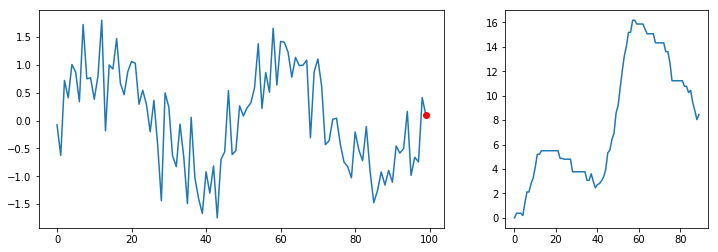

Episode: 469
Reward : 36.435113367514475
Average: 20.611634570164586
----------



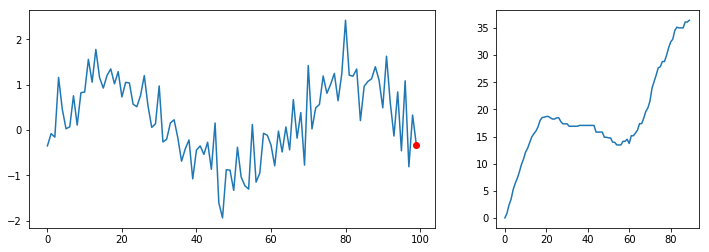

Episode: 479
Reward : 30.49912384471764
Average: 20.221990202487845
----------



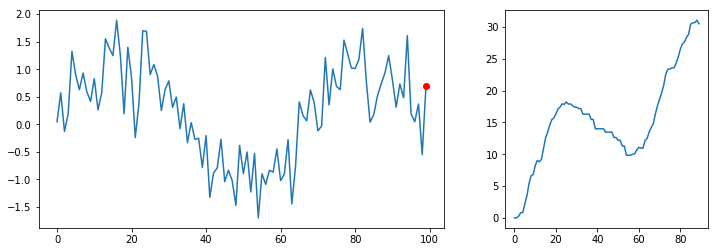

Episode: 489
Reward : 15.283966538505116
Average: 19.634984397886488
----------



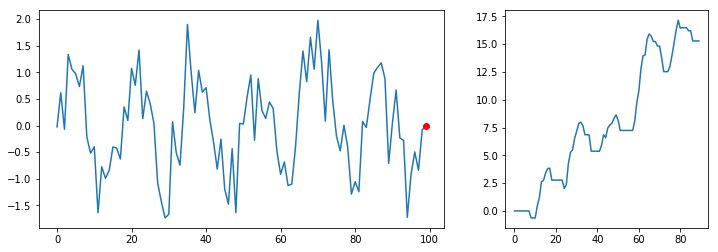

Episode: 499
Reward : 19.138997746970617
Average: 19.404652150812773
----------



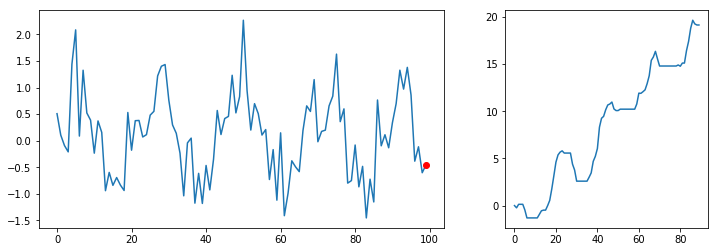

In [171]:
env = SubEnvironment(noise=0.5)
agent = SubAgent(env=env)
rh = agent.run(env, 500, verbose=True)

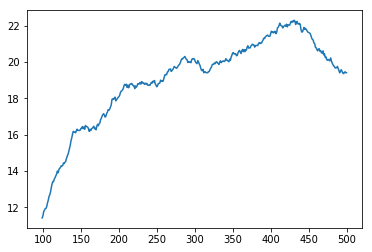

In [174]:
pd.Series(rh).rolling(100).mean().plot()

Here, we test our trained subagent on a seeded environment.

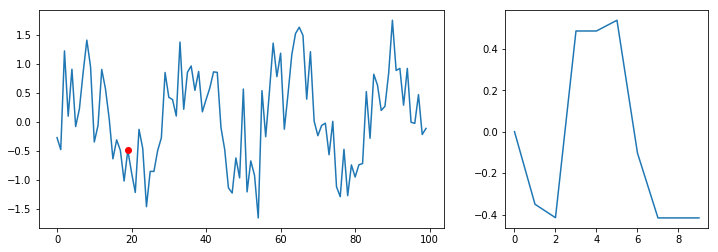

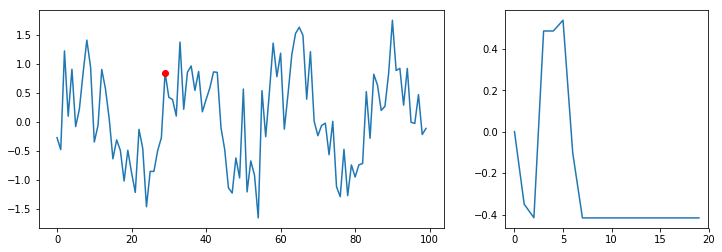

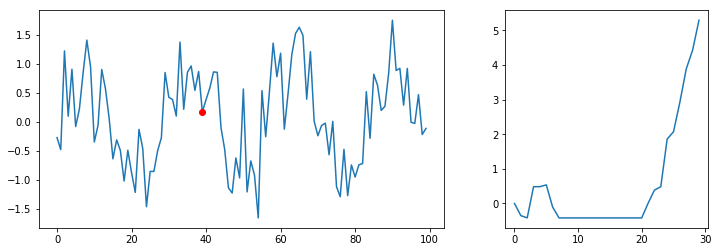

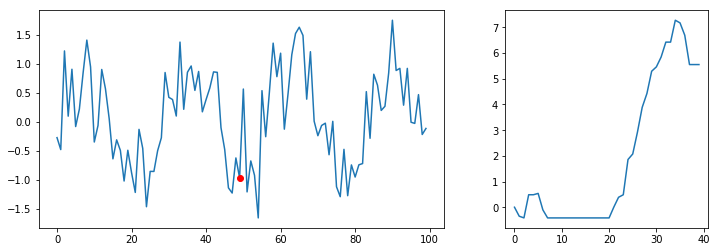

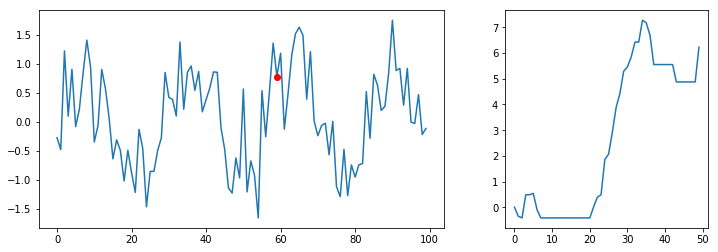

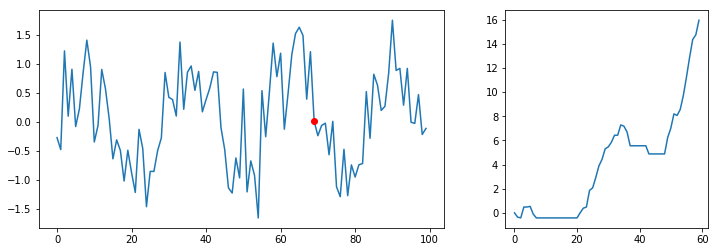

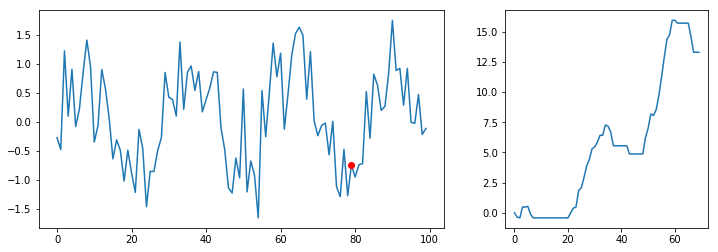

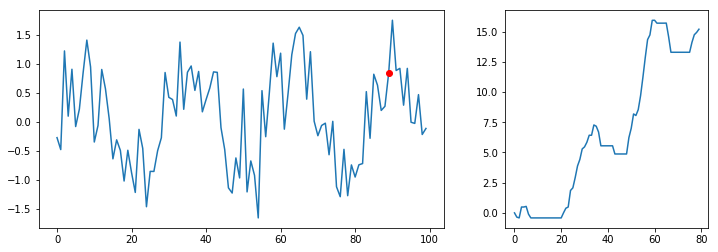

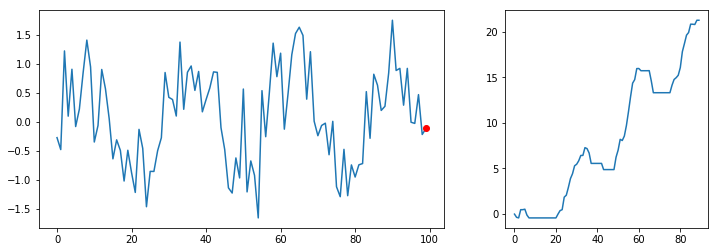

In [175]:
env = SubEnvironment(seed=1, noise=0.5)
obs = env.reset()
done = False
while not done:
    action = agent.get_action(obs)[0]
    obs, rew, done, info = env.step(action)
    if (env.t + 1) % 10 == 0:
        env.render()

Then, for comparison, we test the same environment as above on an untrained agent.

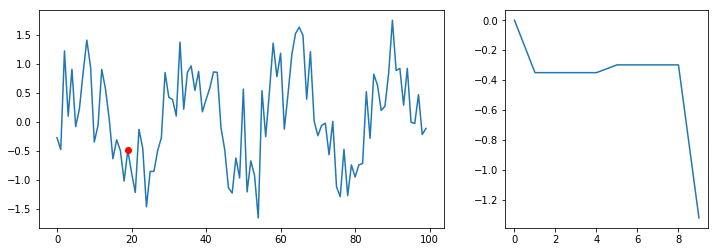

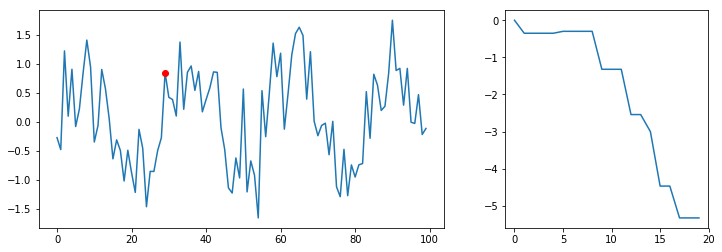

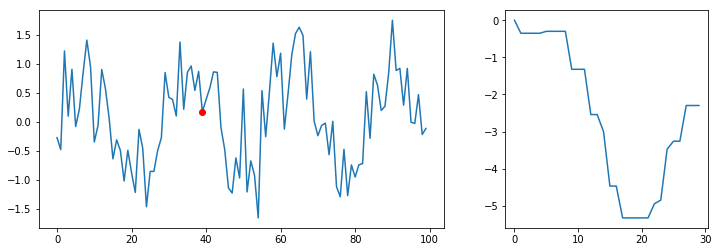

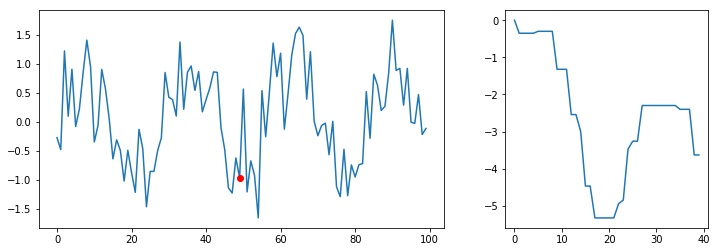

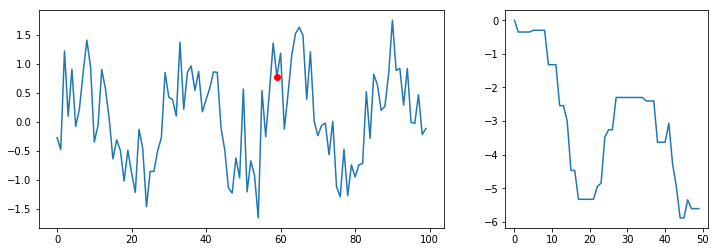

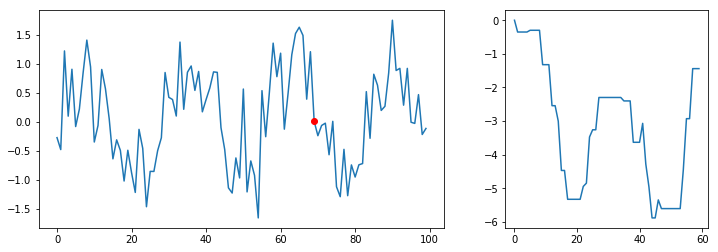

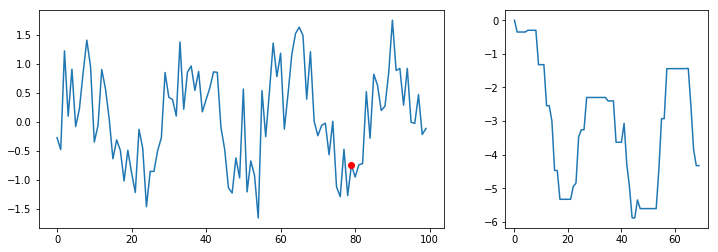

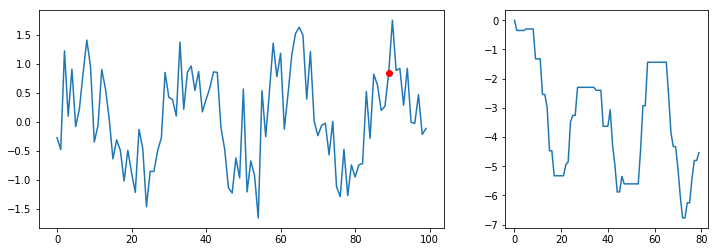

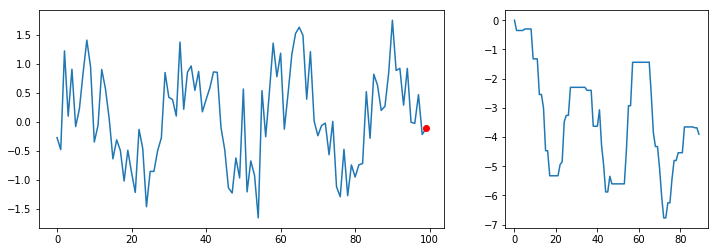

In [176]:
env = SubEnvironment(seed=1, noise=0.5)
untrained_agent = SubAgent(env=env)
obs = env.reset()
done = False
while not done:
    action = untrained_agent.get_action(obs)[0]
    obs, rew, done, info = env.step(action)
    if (env.t + 1) % 10 == 0:
        env.render()

As we can see, the trained agent performs considerably better than the untrained agent.  Granted, the task is relatively easy, but the main point is that our subagents can perform better on the environment than a random agent.